# Atari Game (Pac-Man)

### If not working install in terminal

#### Note from Axtan: This simulation can be run in a custom-made terminal environment and needs Matplotlib installed and scipy in the terminal, not just the notebook. The simulation might not run as well on cloud services, and might not work without the custom terminal (I haven't tested it outside this environment yet)

#### Question

Each time Pac-Man eats a power pellet, there’s a 60% chance he catches at least one ghost before the effect wears off. If he eats 8 power pellets in a game, what is the probability that he catches ghosts 3 times?

#### Description

I need to assume that the player has 3 lives per game.

I need to find how many dots there are on a Pac-Man map, then simulate that

One trial of my simulation will consist of the player picking up all the dots and finding if they catch 5 ghosts or not

The success outcome is that the player dies a total of 3 times; failure is any number that isn't 3 times.

A possible bias in my data is that in my code, the chance that Pac-Man “catches a ghost” is purely based on a random 60% chance per pellet.
However, in the real game, this chance isn’t actually random — it depends on:

In [2]:
!pip install gymnasium
!pip install "gymnasium[atari]"
!pip install ale-py
!pip install autorom[accept-rom-license]
!pip install matplotlib
!pip install scipy

In [1]:
import ale_py
import gymnasium as gym

# Register the ALE environments
gym.register_envs(ale_py)

# Now check the registry
gym.pprint_registry()

===== classic_control =====
Acrobot-v1                  CartPole-v0                 CartPole-v1
MountainCar-v0              MountainCarContinuous-v0    Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0          phys2d/CartPole-v1          phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3            BipedalWalkerHardcore-v3    CarRacing-v3
LunarLander-v3              LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1                CliffWalking-v1             CliffWalkingSlippery-v1
FrozenLake-v1               FrozenLake8x8-v1            Taxi-v3
===== tabular =====
tabular/Blackjack-v0        tabular/CliffWalking-v0
===== None =====
Ant-v2                      Ant-v3                      GymV21Environment-v0
GymV26Environment-v0        HalfCheetah-v2              HalfCheetah-v3
Hopper-v2                   Hopper-v3                   Humanoid-v2
Humanoid-v3                 HumanoidStandup-v2          InvertedDoublePendulum-v2
InvertedPendulum-v2         Pusher-v2             

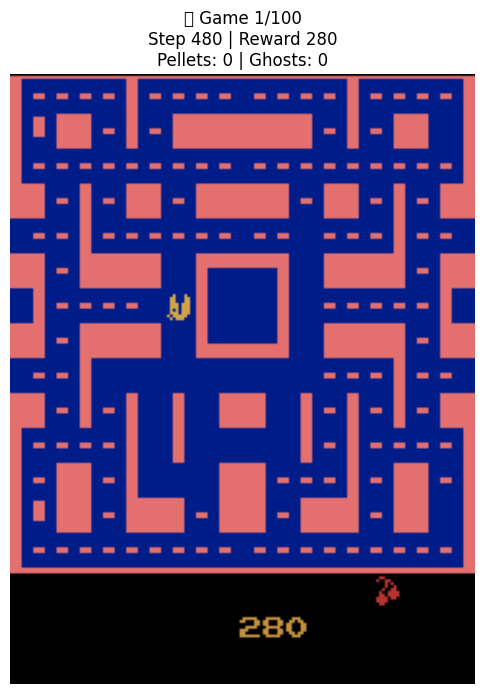

===== SAMPLE STATS =====
Avg pellets per game: 0.74
Avg ghosts per game:  29.73
Games with ≥1 pellet: 47.0%

===== RESULTS =====
Target ghosts (exactly): 2
Theoretical probability (avg): 0.0857
Empirical probability:         0.0000
Simulated games: 100


In [13]:
import gymnasium as gym
import numpy as np
import random
from scipy.stats import binom
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# ---------- PARAMETERS ----------
p_catch = 0.6             # probability Pac-Man catches ≥1 ghost per pellet
power_mode_duration = 80  # frames pellet effect lasts
games_to_visualize = 1   # show this many games with rendering
games_to_simulate = 100   # total simulated games
target_ghosts = 2         # we’ll look for exactly 2 ghosts caught

# ---------- ENV SETUP ----------
env = gym.make('ALE/MsPacman-v5', render_mode='rgb_array')

total_ghosts_caught = []
total_pellets_eaten = []

# ---------- RUN GAMES (visualize first few) ----------
fig, ax = plt.subplots(figsize=(6,8))
ax.axis('off')
display(fig)

for game in range(games_to_simulate):
    obs, info = env.reset()
    pellets = 0
    ghosts = 0
    power_mode = False
    power_timer = 0
    total_reward = 0.0

    steps = 800 if game < games_to_visualize else 400
    for step in range(steps):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        # --- Simulate random pellet encounters ---
        # Small random chance each frame to "find" a pellet
        if random.random() < 0.002:  # ~0.2% chance per frame
            pellets += 1
            power_mode = True
            power_timer = power_mode_duration

        # --- Ghost catching during power mode ---
        if power_mode:
            # Each frame of power mode, chance to catch ghost(s)
            if random.random() < p_catch:
                ghosts += 1
            power_timer -= 1
            if power_timer <= 0:
                power_mode = False

        # --- Visualization (first few games only) ---
        if game < games_to_visualize:
            clear_output(wait=True)
            ax.clear()
            ax.imshow(env.render())
            ax.set_title(
                f"🎮 Game {game+1}/{games_to_simulate}\n"
                f"Step {step} | Reward {total_reward:.0f}\n"
                f"Pellets: {pellets} | Ghosts: {ghosts}"
            )
            ax.axis('off')
            display(fig)
            time.sleep(0.02)

        if terminated or truncated:
            break

    total_ghosts_caught.append(ghosts)
    total_pellets_eaten.append(pellets)

plt.close()
env.close()

# ---------- DIAGNOSTICS ----------
total_ghosts_caught = np.array(total_ghosts_caught)
total_pellets_eaten = np.array(total_pellets_eaten)

print("===== SAMPLE STATS =====")
print(f"Avg pellets per game: {total_pellets_eaten.mean():.2f}")
print(f"Avg ghosts per game:  {total_ghosts_caught.mean():.2f}")
print(f"Games with ≥1 pellet: {(total_pellets_eaten>0).mean()*100:.1f}%")

# ---------- EMPIRICAL PROBABILITY ----------
empirical_prob = np.mean(total_ghosts_caught == target_ghosts)

# ---------- THEORETICAL PROBABILITY ----------
# Use per-game pellets as n in the binomial model
theoretical_probs = []
for pe in total_pellets_eaten:
    n = int(pe)
    if n >= target_ghosts:
        theoretical_probs.append(binom.pmf(target_ghosts, n, p_catch))
    else:
        theoretical_probs.append(0)
theoretical_prob_avg = np.mean(theoretical_probs)

# ---------- OUTPUT RESULTS ----------
print("\n===== RESULTS =====")
print(f"Target ghosts (exactly): {target_ghosts}")
print(f"Theoretical probability (avg): {theoretical_prob_avg:.4f}")
print(f"Empirical probability:         {empirical_prob:.4f}")
print(f"Simulated games: {games_to_simulate}")


In [7]:
# after running your simulations and collecting total_pellets_eaten (list) and total_ghosts_caught
import numpy as np
from scipy.stats import binom

target_ghosts = 2
p_catch = 0.6

# theoretical per-game (using observed pellet counts) then averaged
per_game_theoretical = [
    binom.pmf(target_ghosts, pe, p_catch) if pe >= target_ghosts else 0.0
    for pe in total_pellets_eaten
]
theoretical_prob_avg = np.mean(per_game_theoretical)

empirical_prob = np.mean(np.array(total_ghosts_caught) == target_ghosts)

print(f"Avg theoretical (per-game pellets): {theoretical_prob_avg:.4f}")
print(f"Empirical prob: {empirical_prob:.4f}")


Avg theoretical (per-game pellets): 0.0000
Empirical prob: 0.0000


In [5]:
import matplotlib.pyplot as plt
print("Matplotlib is installed!")


Matplotlib is installed!


In [7]:
import sys
print(sys.executable)


C:\Users\agilbert3\AppData\Local\anaconda3\envs\gym_env\python.exe


In [6]:
from scipy import stats
print("Scipy is installed and stats is ready!")


Scipy is installed and stats is ready!


### Answer

Running my simulation I discovered a lot of things and ran into a lot of problems while crafting it. The question, "Each time Pac-Man eats a power pellet, there’s a 60% chance he catches at least one ghost before the effect wears off. If he eats 8 power pellets in a game, what is the probability that he catches ghosts 3 times?" Is flawed and overestimated what can be done with the engine. The theoretical probability I calculated was .0857% and I ended up running 100 trials since thats all the simulation could do without crashing or taking years, and I ended up getting an emperical of 0 because of this. Since pacman moves in a random direction he usually dies before picking up a power pellet only 47% of the time he actually ran into a power pellet let alone ran into a ghost after picking it up. He averaged 29 ghosts per game because of the extra pellets I put into the simulation so he could actually get a number, yet he never got exactly 2 ghosts in the simulation because of how many trials I ran which is a bias in my simuluation.